In [1]:
from math import sqrt
import copy

import numpy as np  # linear algebra
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import cv2
from PIL import Image

In [2]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in filter(lambda x: x.endswith('.dcm'), os.listdir(path))]
    slices.sort(key=lambda x: float(x.InstanceNumber))
    return slices


def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    # image[image <= -2000] = 0

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        height, width = image[slice_number].shape[0], image[slice_number].shape[1]
        
        image[slice_number][image[slice_number]<=-2000] = image[slice_number, int(height*0.05), int(width*0.5)]
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)


class Elem():
    def __init__(self, key, contour, t):
        self.root = key
        self.end = key
        self.contours = [contour]
        self.keys = [key]
        self.t = t
        
    def __len__(self):
        return len(self.contours)
    
    def append(self, key, contour):
        self.end = key
        self.contours.append(contour)
        self.keys.append(key)
        
    def get_bboxes(self):
        self.circles = [cv2.minEnclosingCircle(c) for c in self.contours]
        def process(circle):
            cx, cy, r = round(circle[0][0]), round(circle[0][1]), circle[1]
            return cx - int(1.5*r), cy - int(1.5*r), cx + int(1.5*r), cy + int(1.5*r)
            
        self.bboxes = [process(c) for c in self.circles]
        
    def __str__(self):
        return str(self.root)+'->'+str(self.end)+':'+str(self.keys)
    
    def get_prev_area(self):
        return cv2.contourArea(self.contours[-2])
    
    @staticmethod
    def calc_ratio(proportion, kind=0, lower=0.08, upper=0.12):
        if proportion >= upper:
            return 1 if kind == 0 else 1 if kind == 1 else 1.2
        elif proportion <= lower:
            return 3 if kind == 0 else 8 if kind == 1 else 1.5
        else:
            if kind == 0:
                return 2*sqrt((upper-proportion)/(upper-lower))+1 
            elif kind == 1:
                return (upper-proportion)/(upper-lower)*7+1
            else:
                return 0.3*sqrt((upper-proportion)/(upper-lower))+1.2
    
    def post_process(self, patient_pixels, start_x, start_y):       
        self.post_bboxes = []
        img_height, img_width = patient_pixels.shape[1:3]
        start, end = self.root[0], self.end[0]+1
        for i in range(start, end):
            #cx, cy, r = round(self.circles[i-start][0][0]+start_x), round(self.circles[i-start][0][1]+start_y), int(self.circles[i-start][1])
            cx = (self.bboxes[i-start][2]+self.bboxes[i-start][0])//2 + start_x
            cy = (self.bboxes[i-start][3]+self.bboxes[i-start][1])//2 + start_y
            r = int((self.bboxes[i-start][2]-self.bboxes[i-start][0]+1)/3)
            sx, sy = max(0, int(cx-4.5*r)), max(0, int(cy-4.5*r))
            ex, ey = min(img_width, int(cx+4.5*r+1)), min(img_height, int(cy+4.5*r+1))
            gray = patient_pixels[i, sy:ey, sx:ex].astype(np.float32)
            gray = np.clip(gray, 0, 100)
            gray = (gray-gray.min())/(gray.max()-gray.min())*255
            gray = gray.astype(np.uint8)
            gray = cv2.medianBlur(gray, 7)
            # gray = cv2.GaussianBlur(gray, (7,7), 2)
            lap = cv2.Laplacian(gray, cv2.CV_16S)
            gray = gray.astype(np.int16) - lap
            gray = np.clip(gray, 0, 255).astype(np.uint8)
            min_edge = min(img_height, img_width)
            proportion = r*3 / min_edge
            fc = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=min(*gray.shape)//2, param1=200, param2=19, minRadius=r, maxRadius=int(min(min_edge*0.055,r*self.calc_ratio(proportion)+1)))
            if fc is None:
                #self.post_bboxes.append((self.bboxes[i-start][0]+start_x, self.bboxes[i-start][1]+start_y, self.bboxes[i-start][2]+start_x, self.bboxes[i-start][3]+start_y))
                ratio = self.calc_ratio(proportion, kind=2)
                m, n, p, q = cx - int(ratio*r), cy - int(ratio*r), cx + int(ratio*r), cy + int(ratio*r)
                self.post_bboxes.append((m, n, p, q))
#                 if 220 <= i <= 260:
#                     print(f'{i}:put origin')
            else:
                if len(fc) != 1:
                    raise Exception(f'len(fc) == {len(fc)}')
                fc = fc[0]
#                 if 220 <= i <= 260:
#                     print(f'{i}:{fc}')
                for circle in fc:
                    fx, fy, fr = round(circle[0]+sx), round(circle[1]+sy), int(circle[2])
                    assert fr >= r
                    dis = sqrt((fx-cx)**2+(fy-cy)**2)
#                     if 220 <= i <= 260:
#                         print(f'{i}:fr:{fr},r:{r}|{0.5*(fr-r)}<{dis}<{fr - r/self.calc_ratio(proportion, 1)} and {(fr-r)/r}>0.1')
                    if 0.5*(fr-r) < dis < fr - r/self.calc_ratio(proportion, 1) and (fr-r)/r > 0.1:
                        m, n, p, q = fx-int(1.3*fr), fy-int(1.3*fr), fx+int(1.3*fr), fy+int(1.3*fr)
                        self.post_bboxes.append((m, n, p, q))
#                         if 220 <= i <= 260:
#                             print(f'{i}:put new')
                        break
                else:
                    #self.post_bboxes.append((self.bboxes[i-start][0]+start_x, self.bboxes[i-start][1]+start_y, self.bboxes[i-start][2]+start_x, self.bboxes[i-start][3]+start_y))
                    ratio = self.calc_ratio(proportion, kind=2)
                    m, n, p, q = cx - int(ratio*r), cy - int(ratio*r), cx + int(ratio*r), cy + int(ratio*r)
                    self.post_bboxes.append((m, n, p, q))
#                     if 220 <= i <= 260:
#                         print(f'{i}:put origin')
                    
    def blur_bboxes(self, kind=0):
        if kind == 0:
            bboxes = self.bboxes
        else:
            bboxes = self.post_bboxes
            
        xs = [(x1+x2)//2 for x1, y1, x2, y2 in bboxes]
        ys = [(y1+y2)//2 for x1, y1, x2, y2 in bboxes]
        ws = [x2-x1+1 for x1, y1, x2, y2 in bboxes]
        ksize, thresh, dis_thresh = 8, 0.20, 0.20
        if len(bboxes) < 300:
            ksize, thresh, dis_thresh = 5, 0.25, 0.25
        for i in range(ksize, len(bboxes)-ksize):
            mxs = sorted(xs[i-ksize: i+ksize+1])
            mys = sorted(ys[i-ksize: i+ksize+1])
            mws = sorted(ws[i-ksize: i+ksize+1])
            cx, cy, cw = mxs[ksize], mys[ksize], mws[ksize]
            if abs(cw-ws[i]) > cw * thresh:
                r = cw//2
                bboxes[i] = (cx-r, cy-r, cx+r, cy+r)
            elif kind == 1:
                dis = sqrt((cx-xs[i])**2+(cy-ys[i])**2)
                if dis > cw * dis_thresh:
                    r = cw//2
                    bboxes[i] = (cx-r, cy-r, cx+r, cy+r)

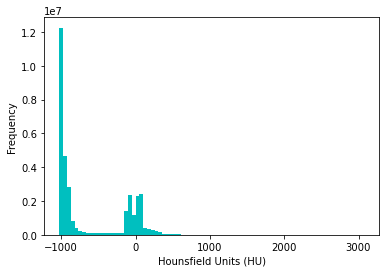

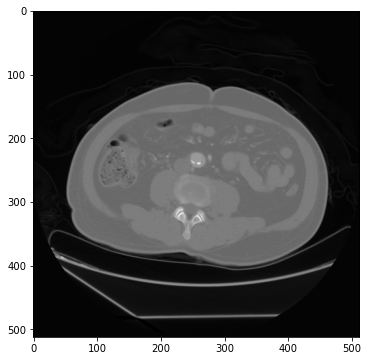

sequence length: 129, height: 512, width: 512


In [46]:
INPUT_FOLDER = '/nfs3-p1/zsxm/dataset/aorta/shuzhiming-Im28-80/2/'

patient = load_scan(INPUT_FOLDER)
patient_pixels = get_pixels_hu(patient)

plt.hist(patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.figure(figsize=(6,6))
plt.imshow(patient_pixels[80], cmap=plt.cm.gray)
plt.show()

img_height, img_width = patient_pixels.shape[1:3]
print(f'sequence length: {patient_pixels.shape[0]}, height: {img_height}, width: {img_width}')
spine_x, spine_y = 0, 0

with open(os.path.join(INPUT_FOLDER, 'branch.txt'), 'r') as f:
    txt_result = f.readlines()
    crown_start = int(txt_result[0])
    branch_start = int(txt_result[1])
    aorta_end = int(txt_result[2])

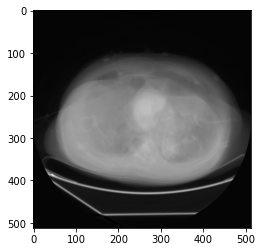

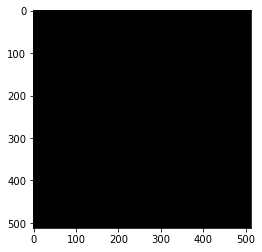

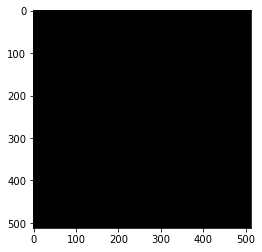

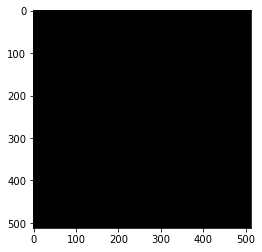

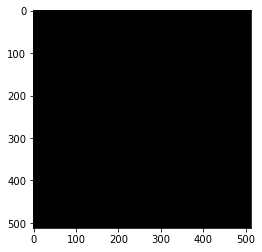

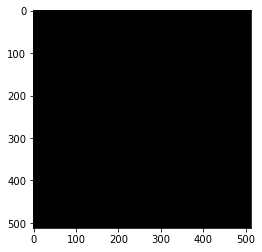

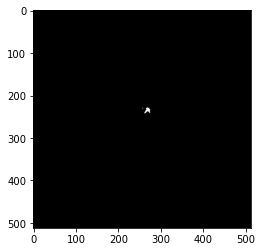

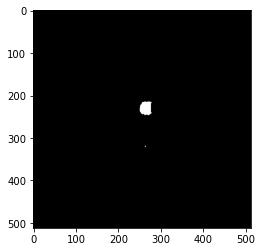

find spine area: 692.5
find spine area: 2.0


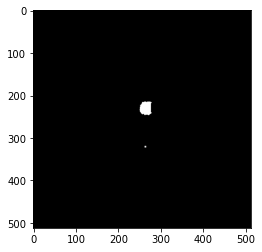

times:0.3


In [47]:
patient_sum = np.sum(patient_pixels, axis=0)
plt.imshow(patient_sum, cmap=plt.cm.gray)
plt.show()
patient_sum = patient_sum.astype(np.float32)
max_val = patient_sum.max()
times = 0.6
while times > 0:
    thr, patient_thr = cv2.threshold(patient_sum, max_val*times, 255, cv2.THRESH_BINARY)
    patient_thr = patient_thr.astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    patient_thr = cv2.erode(patient_thr, kernel, iterations=2)
    # patient_thr = cv2.dilate(patient_thr, kernel, iterations=1)
    plt.imshow(patient_thr, cmap=plt.cm.gray)
    plt.show()
    sum_contours, _ = cv2.findContours(patient_thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sum_contours_list = [(cv2.contourArea(contour), contour) for contour in sum_contours]
    sum_contours_list.sort(key=lambda x: x[0], reverse=True)
    if len(sum_contours_list) == 0 \
    or len(sum_contours_list) > 1 and sum_contours_list[0][0] < 2 * sum_contours_list[1][0] \
    or sum_contours_list[0][0] < img_height*img_width*0.002:
        times -= 0.05
        continue
    find_flag = False
    for area, contour in sum_contours_list:
        print(f'find spine area: {area}')
        x, y, w, h = cv2.boundingRect(contour)
        cx, cy = x+w//2, y+h//2
        if img_height/2 < cy < img_height*0.75 and img_width*0.375 < cx < img_width*0.625:
            cv2.rectangle(patient_thr, (x, y), (x+w, y+h), 255, 1)
            plt.imshow(patient_thr, cmap=plt.cm.gray)
            plt.show()
            spine_x, spine_y = cx, cy
            find_flag = True
            break
    if find_flag:
        print(f'times:{times}')
        break
    times -= 0.05
    
if spine_x == 0 or spine_y == 0:
    raise Exception(f'spine_x:{spine_x}, spine_y:{spine_y}')

In [50]:
def adjust_gamma(img, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    new_img = np.empty(img.shape)
    new_img = cv2.LUT(img, table)
    return new_img

# def set_window(image, w_center, w_width):
#     image_copy = image.copy()
#     image_copy = np.clip(image_copy, w_center-int(w_width/2), w_center+int(w_width/2))
#     image_copy = image_copy.astype(np.float32)
#     image_copy = ((image_copy - image_copy.min())/(image_copy.max() - image_copy.min())*255).astype(np.uint8)
#     for slice_number in range(len(image)):
#         #image_copy[slice_number] = np.int16(cv2.bilateralFilter(image_copy[slice_number].astype(np.float32), 150, 150, 1))
#         #image_copy[slice_number] = np.clip(image_copy[slice_number], w_center-int(w_width/2), w_center+int(w_width/2))
#         min_l = (int(min(image_copy[slice_number].shape[0]*0.3, image_copy[slice_number].shape[1]*0.3))-1) // 2 * 2 + 1
        
#         image_copy[slice_number] = cv2.GaussianBlur(image_copy[slice_number], (3,3), 1)
#         #image_copy[slice_number] = cv2.medianBlur(image_copy[slice_number], 3)
# #         lap = cv2.Laplacian(image_copy[slice_number], cv2.CV_16S)
# #         image_copy[slice_number] = np.clip(image_copy[slice_number].astype(np.int16) - lap, 0, 255).astype(np.uint8)
#         #image_copy[slice_number] = adjust_gamma(image_copy[slice_number], 1/2)
#         #image_copy[slice_number] = cv2.bilateralFilter(image_copy[slice_number], 5, 5, 2, 3)
#         image_copy[slice_number] = cv2.adaptiveThreshold(image_copy[slice_number], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, min_l, 0)
#         #thresh, image_copy[slice_number] = cv2.threshold(image_copy[slice_number], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
#         kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
#         image_copy[slice_number] = cv2.erode(image_copy[slice_number], kernel, iterations=5)
#         image_copy[slice_number] = cv2.dilate(image_copy[slice_number], kernel, iterations=3)
#     return image_copy
def set_window(image, w_center, w_width, crown_start, branch_start):
    image_copy = image.copy()
    image_copy = np.clip(image_copy, w_center-int(w_width/2), w_center+int(w_width/2))
    image_copy = image_copy.astype(np.float32)
    image_copy = ((image_copy - image_copy.min())/(image_copy.max() - image_copy.min())*255).astype(np.uint8)
    for slice_number in range(len(image)):
        min_l = (int(min(image_copy[slice_number].shape[0]*0.3, image_copy[slice_number].shape[1]*0.3))-1) // 2 * 2 + 1
        
        image_copy[slice_number] = cv2.GaussianBlur(image_copy[slice_number], (3,3), 1)
        lap = cv2.Laplacian(image_copy[slice_number], cv2.CV_16S)
        image_copy[slice_number] = np.clip(image_copy[slice_number].astype(np.int16) - lap, 0, 255).astype(np.uint8)
        image_copy[slice_number] = cv2.adaptiveThreshold(image_copy[slice_number], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, min_l, 0)
        
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        if crown_start <= slice_number <= branch_start+1:
            image_copy[slice_number] = cv2.dilate(image_copy[slice_number], kernel, iterations=2)
            image_copy[slice_number] = cv2.erode(image_copy[slice_number], kernel, iterations=7)
            image_copy[slice_number] = cv2.dilate(image_copy[slice_number], kernel, iterations=3)
        else:
            image_copy[slice_number] = cv2.erode(image_copy[slice_number], kernel, iterations=5)
            image_copy[slice_number] = cv2.dilate(image_copy[slice_number], kernel, iterations=3)
    return image_copy

patient_copy = set_window(patient_pixels, 300, 600, crown_start, branch_start)

start_x = int(spine_x-img_width*0.2)
end_x = int(spine_x+img_width*0.2)
start_y = int(spine_y-img_height*0.4)
end_y = int(spine_y+img_height*0.1)
patient_cut = patient_copy[:, start_y:end_y, start_x:end_x]

print(patient_cut.shape)
print(patient_cut.dtype)

(129, 256, 205)
uint8


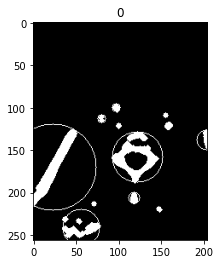

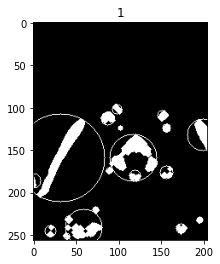

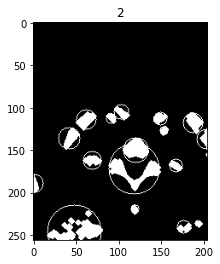

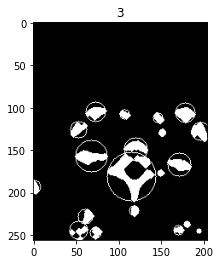

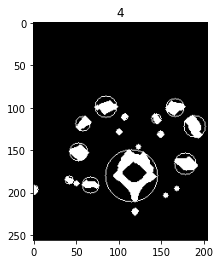

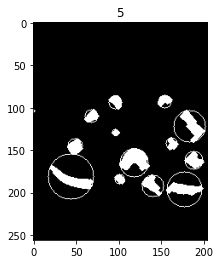

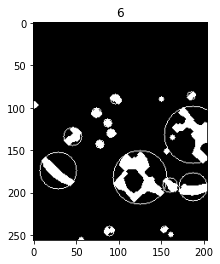

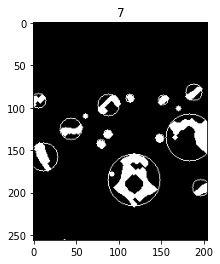

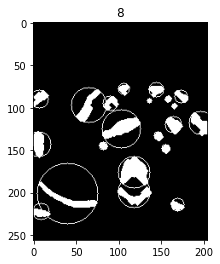

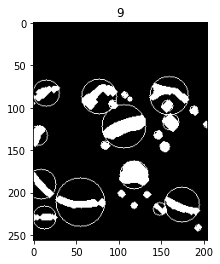

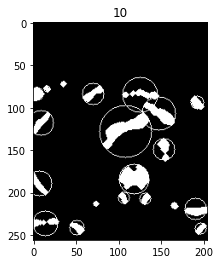

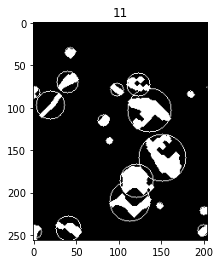

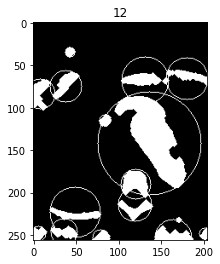

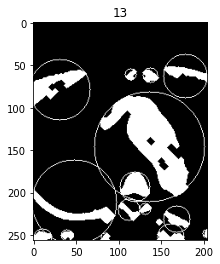

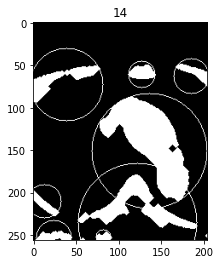

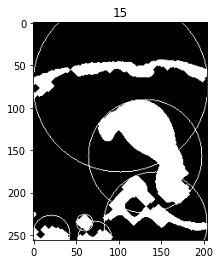

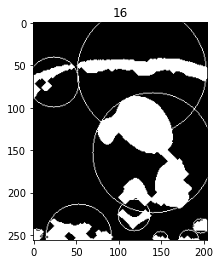

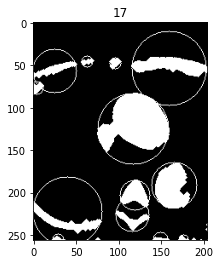

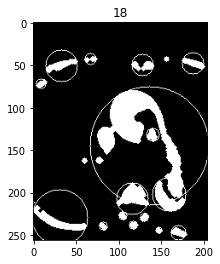

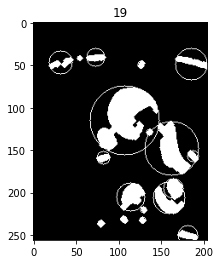

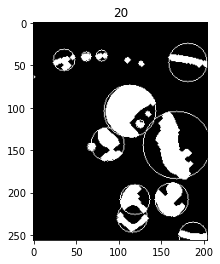

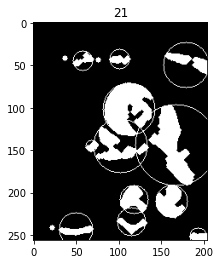

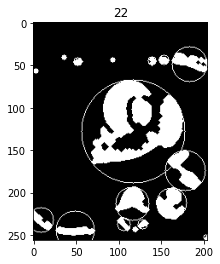

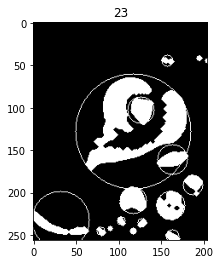

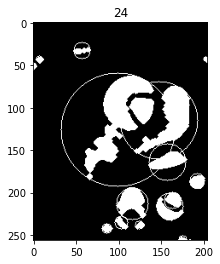

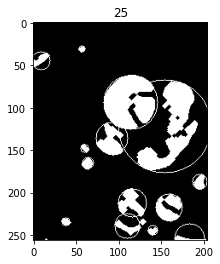

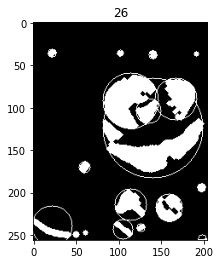

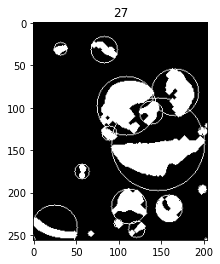

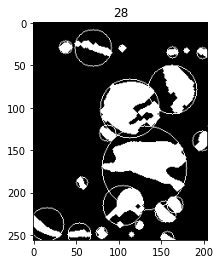

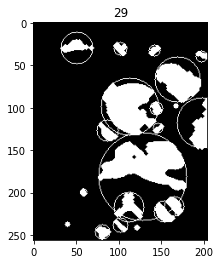

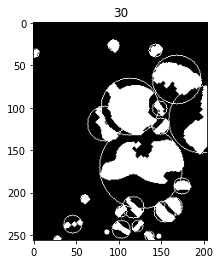

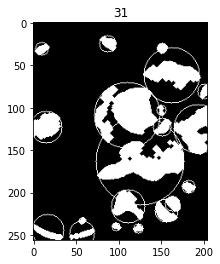

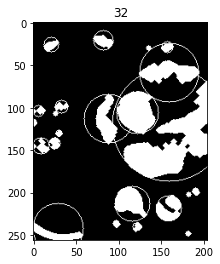

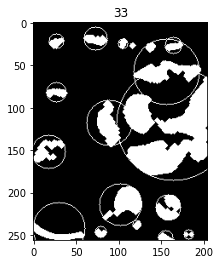

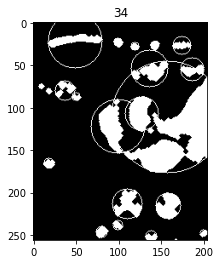

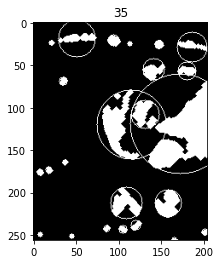

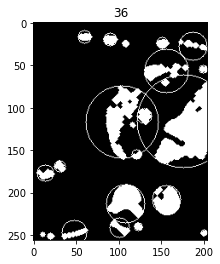

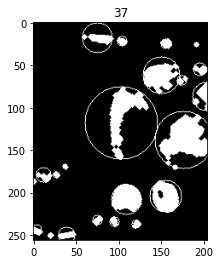

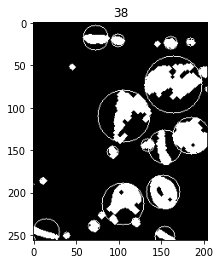

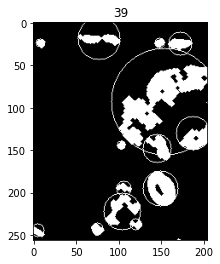

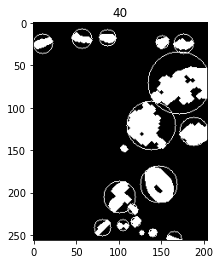

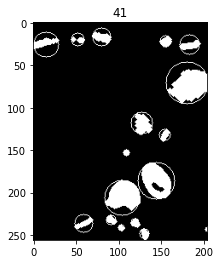

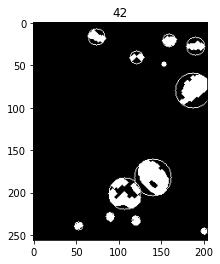

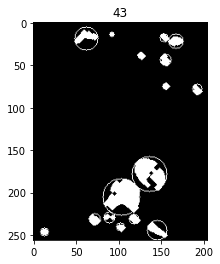

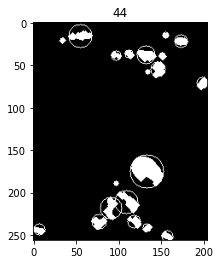

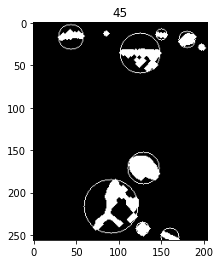

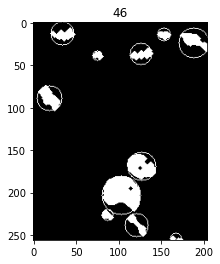

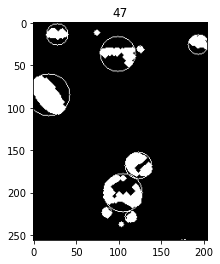

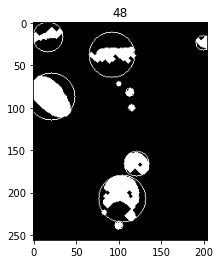

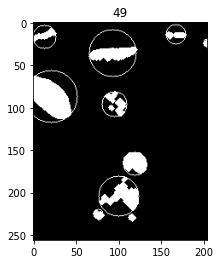

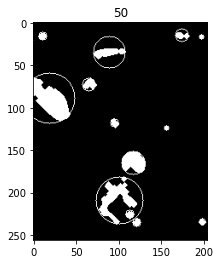

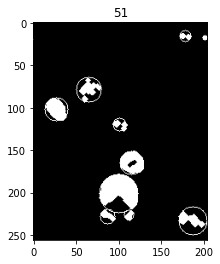

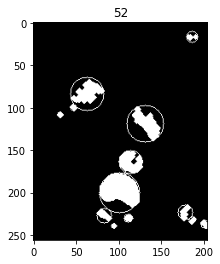

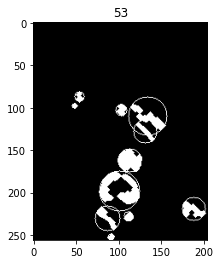

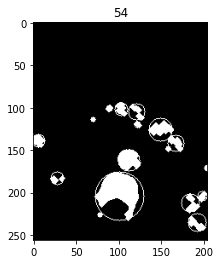

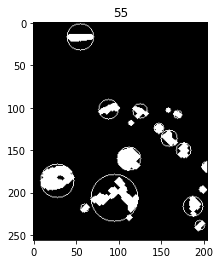

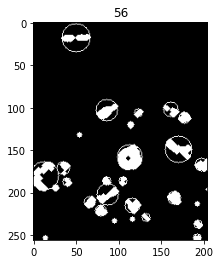

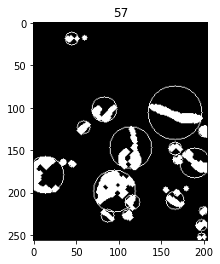

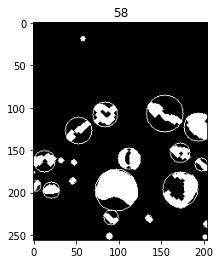

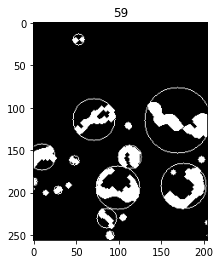

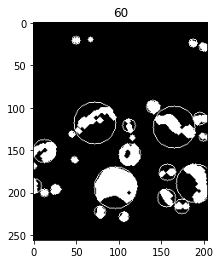

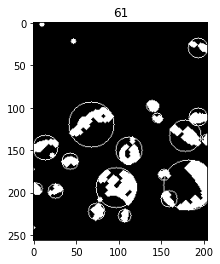

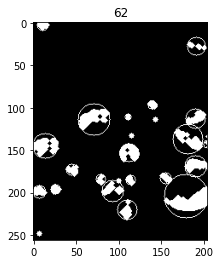

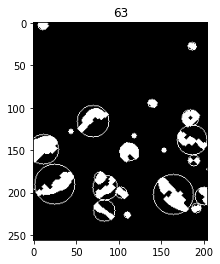

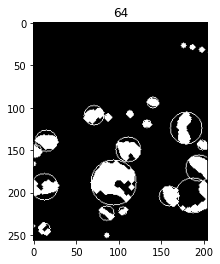

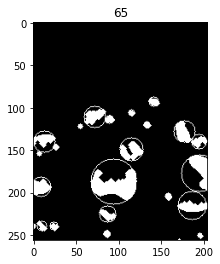

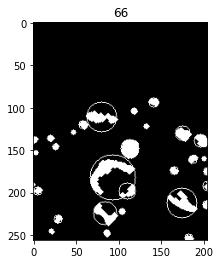

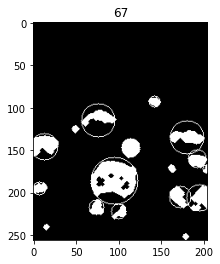

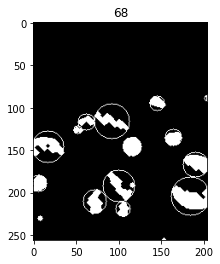

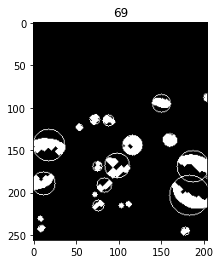

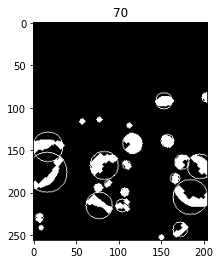

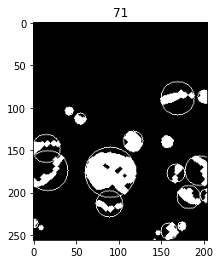

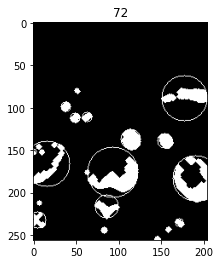

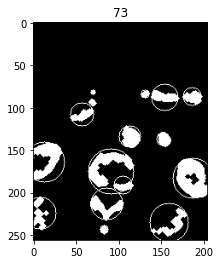

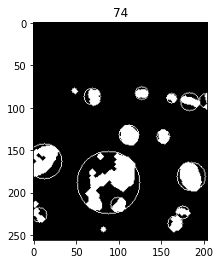

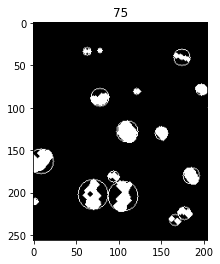

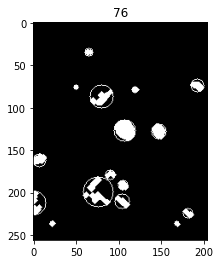

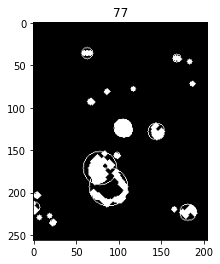

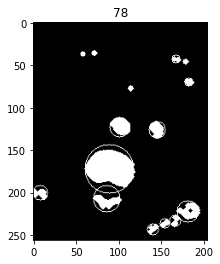

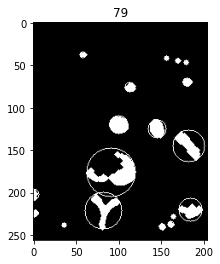

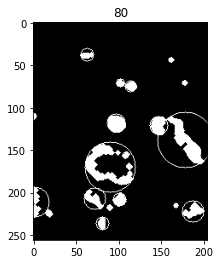

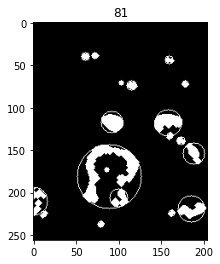

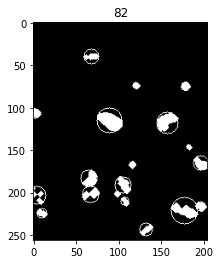

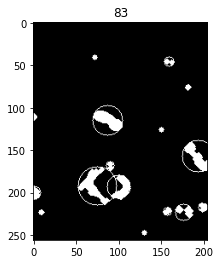

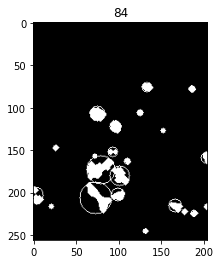

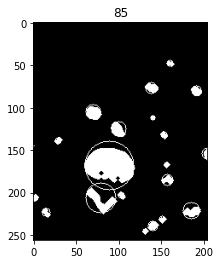

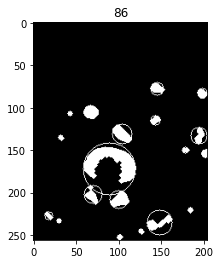

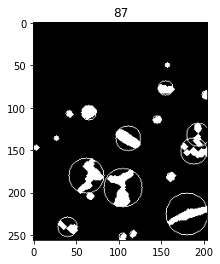

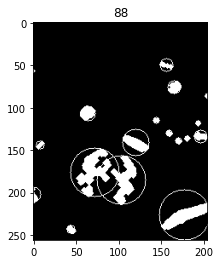

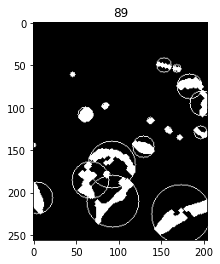

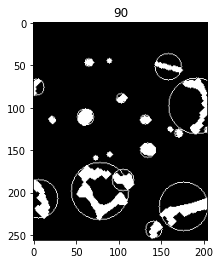

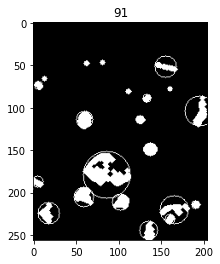

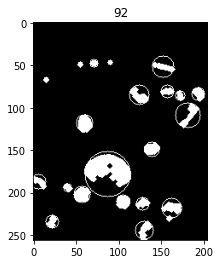

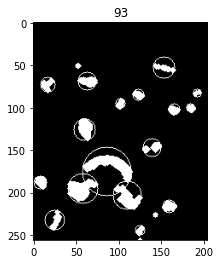

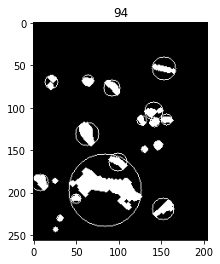

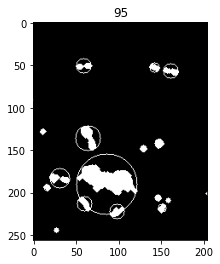

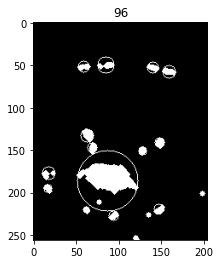

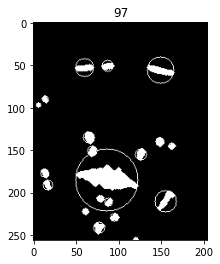

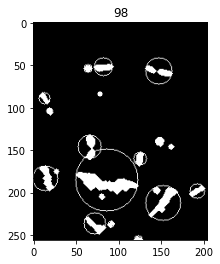

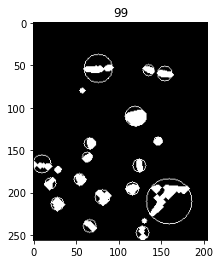

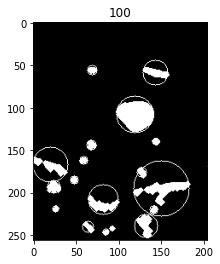

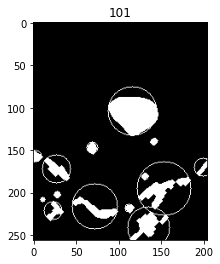

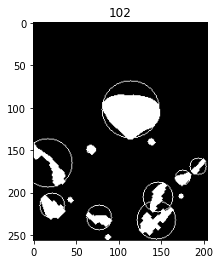

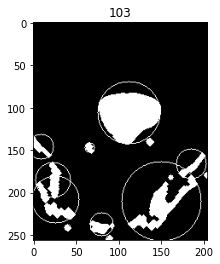

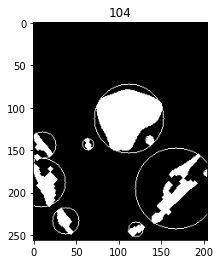

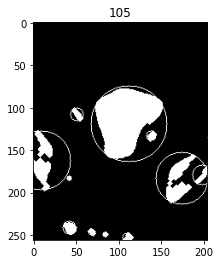

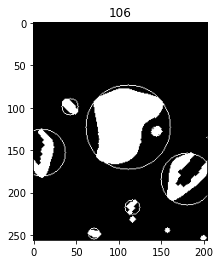

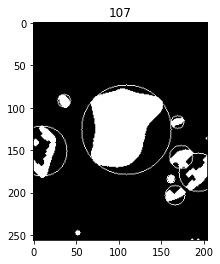

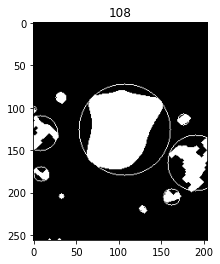

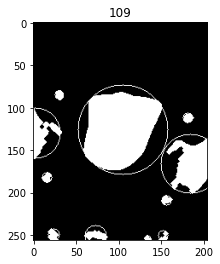

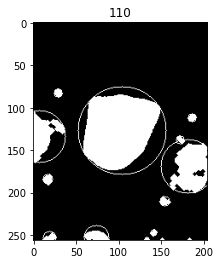

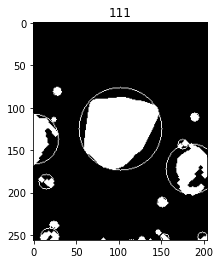

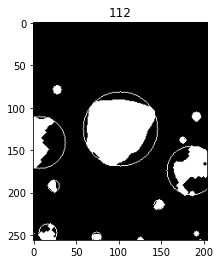

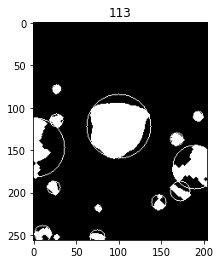

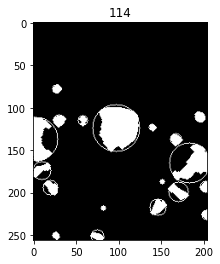

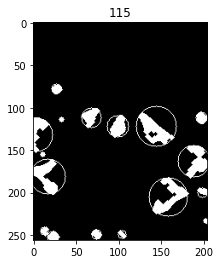

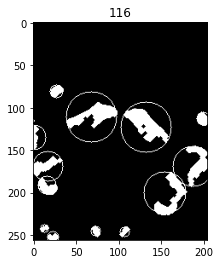

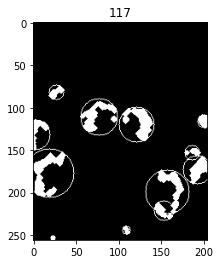

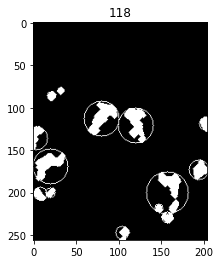

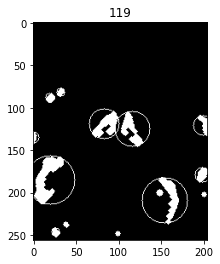

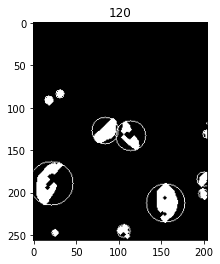

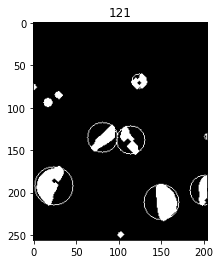

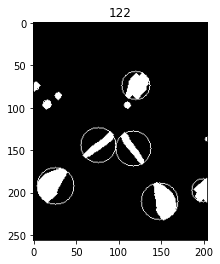

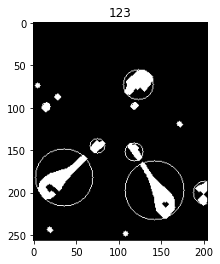

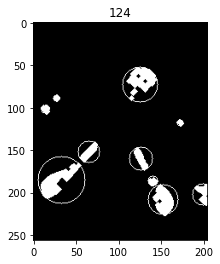

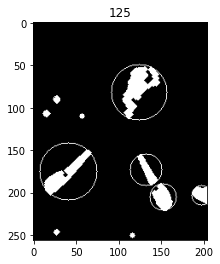

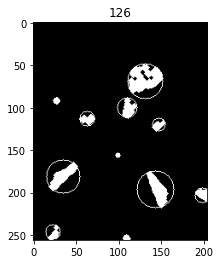

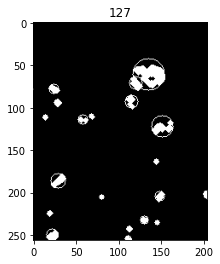

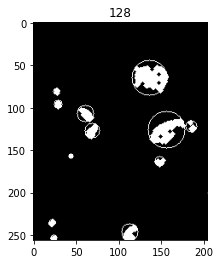

In [51]:
# plt.figure(figsize=(10,10))
# plt.imshow(patient_cut[250], cmap="gray")
# plt.show()
for i in range(len(patient_cut)):
    plt.title(str(i))
#     plt.imshow(patient_cut[i], cmap="gray")
#     plt.show()
    ccc = patient_cut[i].copy()
    con, _  = cv2.findContours(ccc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cc in con:
        cir = cv2.minEnclosingCircle(cc)
        cv2.circle(ccc, (int(cir[0][0]),int(cir[0][1])), int(cir[1]), 255, 1)
    plt.imshow(ccc, cmap="gray")
    plt.show()

In [9]:
def get_intersection(origin, first, second):
    zero1, zero2 = np.zeros_like(origin), np.zeros_like(origin)
    cv2.fillPoly(zero1, [first], 125)
    cv2.fillPoly(zero2, [second], 130)
    inter = zero1 + zero2
    inter[inter<255] = 0
    contours, _ = cv2.findContours(inter, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    inter_area = 0
    for contour in contours:
        inter_area += cv2.contourArea(contour)
    first_area = cv2.contourArea(first)
    second_area = cv2.contourArea(second)
    if first_area == 0 or second_area == 0:
        return 0
    assert inter_area <= first_area and inter_area <= second_area
    return max(inter_area/first_area, inter_area/second_area)

In [18]:
cut_height, cut_width = patient_cut.shape[1:3]
cut_min_side = min(cut_height, cut_width)
pre_contours, _ = cv2.findContours(patient_cut[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
pre_circle = list(map(lambda x: cv2.minEnclosingCircle(x), pre_contours))
path_dict = {}
for i in range(1, len(patient_cut)):
    cur_contours, _ = cv2.findContours(patient_cut[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cur_circle = list(map(lambda x: cv2.minEnclosingCircle(x), cur_contours))
    for j in range(len(pre_circle)):
        if pre_circle[j][0][0] < (0.4)*cut_width \
        or pre_circle[j][0][0] < (0.6)*cut_width and pre_circle[j][0][1] > (0.8)*cut_height:
            continue
        candidate_list = []
        for k in range(len(cur_circle)):
            if cur_circle[k][0][0] < (0.4)*cut_width \
            or cur_circle[k][0][0] < (0.6)*cut_width and cur_circle[k][0][1] > (0.8)*cut_height:
                continue
            dis = sqrt((pre_circle[j][0][0]-cur_circle[k][0][0])**2+(pre_circle[j][0][1]-cur_circle[k][0][1])**2)
            max_r, min_r = max(pre_circle[j][1], cur_circle[k][1]), min(pre_circle[j][1], cur_circle[k][1])
            if dis <= max_r:#dis <= max_r - 0.5 * min_r:
                candidate_list.append((k, cv2.contourArea(cur_contours[k])))
        
        if len(candidate_list) == 0:
            continue
        candidate_list.sort(key=lambda x:x[1])
        path = path_dict.get((i-1, j), Elem((i-1, j), pre_contours[j], t=0))
        temp_path_list = [copy.deepcopy(path) for s in range(len(candidate_list))]
        put_back_flag = False
        for s, candidate in enumerate(candidate_list):
            k = candidate[0]
            if get_intersection(patient_cut[i], pre_contours[j], cur_contours[k]) < 0.6:
                continue
            temp_path_list[s].append((i, k), cur_contours[k])
            if not (i, k) in path_dict \
            or len(path_dict[(i, k)]) < len(temp_path_list[s]) \
            or path_dict[(i, k)].get_prev_area() < temp_path_list[s].get_prev_area():
                path_dict[(i, k)] = temp_path_list[s]
                put_back_flag = True
        if not put_back_flag:
            path_dict[(i-1, j)] = path
    
    pre_contours = cur_contours
    pre_circle = cur_circle

In [19]:
print(len(path_dict))
path_list = list(path_dict.values())
path_list.sort(key=lambda x: len(x), reverse=True)
for i in range(min(5,len(path_list))):
    print(i, ':', len(path_list[i]), path_list[i].root, '->', path_list[i].end)

2868
0 : 265 (36, 19) -> (300, 14)
1 : 264 (36, 19) -> (299, 17)
2 : 263 (36, 19) -> (298, 13)
3 : 262 (36, 19) -> (297, 12)
4 : 262 (36, 19) -> (297, 11)


In [20]:
path = path_list[0]
start = path.root[0]
end = path.end[0]+1

In [ ]:
canvas = np.zeros_like(patient_cut)
start = path.root[0]
end = path.end[0]+1
for i in range(start, end):
    cv2.fillPoly(canvas[i], [path.contours[i-start]], 255)
    circles = list(map(lambda x: cv2.minEnclosingCircle(x), [path.contours[i-start]]))
    for c in circles:
        cv2.circle(canvas[i], (int(c[0][0]),int(c[0][1])), int(c[1]), 128, 1)
    
for i in range(len(canvas)):
    plt.title(str(i))
    plt.imshow(canvas[i], cmap="gray")
    plt.show()

In [21]:
path.get_bboxes()

In [22]:
with open(os.path.join(INPUT_FOLDER, 'branch.txt'), 'r') as f:
    branch_start = int(f.readlines()[1]) + 5
    
assert branch_start > start

pre_w = path.bboxes[branch_start-start][2]-path.bboxes[branch_start-start][0]+1
while branch_start > start:
    cur_w = path.bboxes[branch_start-start-1][2]-path.bboxes[branch_start-start-1][0]+1
    if cur_w - pre_w > 0.5 * pre_w:
        print((cur_w - pre_w)/pre_w)
        break
    branch_start -= 1
    pre_w = cur_w
    
assert branch_start > start

1.2212389380530972


In [23]:
print(branch_start)
print(start)

90
36


In [24]:
branch_path_list = []
for tmp_path in path_list:
    if tmp_path.root == path.root and len(tmp_path) >= branch_start - start + 1:
        print(tmp_path.keys[branch_start-start-1],path.keys[branch_start-start-1])
        print(tmp_path.keys[branch_start-start],path.keys[branch_start-start], '\n')
    if tmp_path.t != path.t or tmp_path.root != path.root or len(tmp_path) < branch_start - start + 1:
        continue
    if tmp_path.keys[branch_start-start-1] == path.keys[branch_start-start-1] and tmp_path.keys[branch_start-start] != path.keys[branch_start-start]:
        branch_path_list.append(tmp_path)

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 8) (89, 8


(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8) 

(89, 8) (89, 8)
(90, 8) (90, 8) 

(89, 9) (89, 8)
(90, 10) (90, 8

In [25]:
print(len(branch_path_list))
branch_path = branch_path_list[0]
branch_path.get_bboxes()

In [28]:
print(branch_path)
print(path_dict[(91,10)])

(36, 19)->(90, 9):[(36, 19), (37, 21), (38, 24), (39, 18), (40, 13), (41, 18), (42, 19), (43, 18), (44, 22), (45, 18), (46, 17), (47, 15), (48, 18), (49, 15), (50, 16), (51, 16), (52, 18), (53, 19), (54, 17), (55, 18), (56, 14), (57, 13), (58, 15), (59, 15), (60, 13), (61, 10), (62, 8), (63, 12), (64, 12), (65, 10), (66, 10), (67, 12), (68, 12), (69, 12), (70, 14), (71, 12), (72, 13), (73, 13), (74, 13), (75, 12), (76, 13), (77, 13), (78, 13), (79, 10), (80, 8), (81, 6), (82, 5), (83, 4), (84, 5), (85, 5), (86, 5), (87, 6), (88, 6), (89, 8), (90, 9)]
(36, 19)->(91, 10):[(36, 19), (37, 21), (38, 24), (39, 18), (40, 13), (41, 18), (42, 19), (43, 18), (44, 22), (45, 18), (46, 17), (47, 15), (48, 18), (49, 15), (50, 16), (51, 16), (52, 18), (53, 19), (54, 17), (55, 18), (56, 14), (57, 13), (58, 15), (59, 15), (60, 13), (61, 10), (62, 8), (63, 12), (64, 12), (65, 10), (66, 10), (67, 12), (68, 12), (69, 12), (70, 14), (71, 12), (72, 13), (73, 13), (74, 13), (75, 12), (76, 13), (77, 13), (78,

In [ ]:
branch_end = branch_start+1
pre_w = branch_path.bboxes[branch_start-start][2]-branch_path.bboxes[branch_start-start][0]+1
while branch_end < branch_path.end[0]+1:
    cur_w = branch_path.bboxes[branch_end-start][2]-branch_path.bboxes[branch_end-start][0]+1
    if cur_w - pre_w > 0.5 * pre_w:
        print((cur_w - pre_w)/pre_w)
        break
    branch_end += 1
    pre_w = cur_w

print(branch_end)
assert branch_end < end

In [ ]:
path2 = branch_path_list[0]
canvas = np.zeros_like(patient_cut)
start2 = path2.root[0]
end2 = path2.end[0]+1
for i in range(start2, end2):
    cv2.fillPoly(canvas[i], [path2.contours[i-start]], 255)
    circles = list(map(lambda x: cv2.minEnclosingCircle(x), [path2.contours[i-start2]]))
    for c in circles:
        cv2.circle(canvas[i], (int(c[0][0]),int(c[0][1])), int(c[1]), 128, 1)
    
for i in range(len(canvas)):
    plt.title(str(i))
    plt.imshow(canvas[i], cmap="gray")
    plt.show()

In [ ]:
def set_window2(image, w_center, w_width):
    image_copy = image.copy().astype(np.float32)
    for slice_number in range(len(image_copy)):
        image_copy[slice_number] = np.clip(image_copy[slice_number], w_center-int(w_width/2), w_center+int(w_width/2))
        image_copy[slice_number] = (image_copy[slice_number]-image_copy[slice_number].min())/(image_copy[slice_number].max()-image_copy[slice_number].min())
    
    return image_copy

In [ ]:
patient_img = set_window2(patient_pixels, 40, 400)

start = path.root[0]
end = path.end[0]+1
for i in range(start, end):
    x1, y1 = path.bboxes[i-start][0] + start_x, path.bboxes[i-start][1] + start_y
    x2, y2 = path.bboxes[i-start][2] + start_x, path.bboxes[i-start][3] + start_y
    cv2.rectangle(patient_img[i], (x1, y1), (x2, y2), 1, 2)
    
for i in range(len(patient_img)):
    plt.title(str(i))
    plt.imshow(patient_img[i], cmap="gray")
    plt.show()

In [ ]:
patient_img = set_window2(patient_pixels, 40, 400)

for i in range(branch_start, branch_end):
    x1, y1 = branch_path.bboxes[i-start][0] + start_x, branch_path.bboxes[i-start][1] + start_y
    x2, y2 = branch_path.bboxes[i-start][2] + start_x, branch_path.bboxes[i-start][3] + start_y
    cv2.rectangle(patient_img[i], (x1, y1), (x2, y2), 1, 2)
    
for i in range(len(patient_img)):
    plt.title(str(i))
    plt.imshow(patient_img[i], cmap="gray")
    plt.show()

In [ ]:
path.blur_bboxes(kind=0)
branch_path.blur_bboxes(kind=0)

In [ ]:
patient_img = set_window2(patient_pixels, 40, 400)

start = path.root[0]
end = path.end[0]+1
for i in range(start, end):
    x1, y1 = path.bboxes[i-start][0] + start_x, path.bboxes[i-start][1] + start_y
    x2, y2 = path.bboxes[i-start][2] + start_x, path.bboxes[i-start][3] + start_y
    cv2.rectangle(patient_img[i], (x1, y1), (x2, y2), 1, 2)
    
for i in range(len(patient_img)):
    plt.title(str(i))
    plt.imshow(patient_img[i], cmap="gray")
    plt.show()

In [ ]:
path.post_process(patient_pixels, start_x, start_y)
#branch_path.post_process(patient_pixels, start_x, start_y)

In [ ]:
patient_img = set_window2(patient_pixels, 40, 400)

start = path.root[0]
end = path.end[0]+1
for i in range(start, end):
    x1, y1 = path.post_bboxes[i-start][0], path.post_bboxes[i-start][1]
    x2, y2 = path.post_bboxes[i-start][2], path.post_bboxes[i-start][3]
    cv2.rectangle(patient_img[i], (x1, y1), (x2, y2), 1, 2)
    
# for i in range(len(patient_img)):
#     plt.title(str(i))
#     plt.imshow(patient_img[i], cmap="gray")
#     plt.show()
    
for i in range(start, end):
    w = path.bboxes[i-start][2] - path.bboxes[i-start][0]
    h = path.post_bboxes[i-start][3] - path.post_bboxes[i-start][1]
    plt.title(str(i-start)+':'+str((w, h)))
    plt.imshow(patient_img[i], cmap="gray")
    plt.show()

In [ ]:
path.blur_bboxes(kind=1)
#branch_path.blur_bboxes(kind=1)

In [ ]:
patient_img = set_window2(patient_pixels, 40, 400)

start = path.root[0]
end = path.end[0]+1
for i in range(start, end):
    x1, y1 = path.post_bboxes[i-start][0], path.post_bboxes[i-start][1]
    x2, y2 = path.post_bboxes[i-start][2], path.post_bboxes[i-start][3]
    cv2.rectangle(patient_img[i], (x1, y1), (x2, y2), 1, 2)
    
# for i in range(len(patient_img)):
#     plt.title(str(i))
#     plt.imshow(patient_img[i], cmap="gray")
#     plt.show()
    
for i in range(start, end):
    w = path.bboxes[i-start][2] - path.bboxes[i-start][0] + 1
    h = path.post_bboxes[i-start][3] - path.post_bboxes[i-start][1] + 1
    plt.title(str(i-start)+':'+str((w, h)))
    plt.imshow(patient_img[i], cmap="gray")
    plt.show()

In [ ]:
94-104
268-279

In [ ]:
patient_img = set_window2(patient_pixels, 40, 400)

start = path.root[0]
end = path.end[0]+1
for i in range(branch_start, branch_end):
    x1, y1 = branch_path.bboxes[i-start][0] + start_x, branch_path.bboxes[i-start][1] + start_y
    x2, y2 = branch_path.bboxes[i-start][2] + start_x, branch_path.bboxes[i-start][3] + start_y
    cv2.rectangle(patient_img[i], (x1, y1), (x2, y2), 1, 2)
    
for i in range(branch_start, branch_end):
    w = branch_path.bboxes[i-start][2] - branch_path.bboxes[i-start][0] + 1
    h = branch_path.post_bboxes[i-start][3] - branch_path.post_bboxes[i-start][1] + 1
    plt.title(str(i-branch_start)+':'+str((w, h)))
    plt.imshow(patient_img[i], cmap="gray")
    plt.show()

In [ ]:
def draw_bbox(slices, path, start_x, start_y, save_path):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    for i, s in enumerate(slices):
        
        img = s.pixel_array
        if path.root[0] <= i <= path.end[0]:
            x1, y1 = path.post_bboxes[i-start][0] + start_x, path.post_bboxes[i-start][1] + start_y
            x2, y2 = path.post_bboxes[i-start][2] + start_x, path.post_bboxes[i-start][3] + start_y
            cv2.rectangle(img, (x1, y1), (x2, y2), 3000, 1)
        s.PixelData = pydicom.encaps.encapsulate([img.tobytes()])
        s.file_meta.TransferSyntaxUID = '1.2.840.10008.1.2.1'
        s.save_as(os.path.join(save_path, f'{i}.dcm'), write_like_original=False)

In [ ]:
patient = load_scan(INPUT_FOLDER)
draw_bbox(patient, path, 0, 0, os.path.join(INPUT_FOLDER, 'save_post'))

In [ ]:
x1, y1 = path.bboxes[77-start][0] + start_x, path.bboxes[77-start][1] + start_y
x2, y2 = path.bboxes[77-start][2] + start_x, path.bboxes[77-start][3] + start_y
cx, cy = (x1+x2)//2, (y1+y2)//2
w, h = x2-x1, y2-y1
sx, sy = cx-int(1.5*w), cy-int(1.5*h)
ex, ey = cx+int(1.5*w), cy+int(1.5*h)
cv2.rectangle(patient_img[170], (sx, sy), (ex, ey), 1, 2)
plt.imshow(patient_img[77], cmap="gray")
plt.show()

In [ ]:
gray = patient_pixels[77, sy:ey, sx:ex].astype(np.float32)
gray = np.clip(gray, -100, 100)
gray = (gray-gray.min())/(gray.max()-gray.min())*255
gray = gray.astype(np.uint8)
#gray = adjust_gamma(gray, 1)
plt.imshow(gray, cmap="gray")
plt.show()

In [ ]:
gray2 = cv2.medianBlur(gray, 7)
# gray2 = cv2.GaussianBlur(gray, (5,5), 2)
plt.imshow(gray2, cmap="gray")
plt.show()
lap = cv2.Laplacian(gray2, cv2.CV_16S)
plt.imshow(lap, cmap="gray")
plt.show()
gray2 = gray2.astype(np.int16)
gray2 -= lap
gray2 = np.clip(gray2, 0, 255).astype(np.uint8)
plt.imshow(gray2, cmap="gray")
plt.show()
cann = cv2.Canny(gray2, 100, 50)
plt.imshow(cann, cmap="gray")
plt.show()

In [ ]:
minr = int(path.circles[77-start][1])
fcir = cv2.HoughCircles(gray2,cv2.HOUGH_GRADIENT,dp=1, minDist=min(*gray.shape)//10, param1=200,param2=10,minRadius=minr,maxRadius=minr*3)
print(fcir)

In [ ]:
for i in range(len(fcir[0])):
    gcanvas = gray2.copy()
    cv2.circle(gcanvas, (int(fcir[0][i][0]), int(fcir[0][i][1])), int(fcir[0][i][2]), 255, 1)
    plt.title(f'{i}')
    plt.imshow(gcanvas, cmap='gray')
    plt.show()

In [ ]:
print(min(*patient_cut.shape))

In [ ]:
print(type(patient[0].SOPInstanceUID))

In [ ]:
print((patient[50].SOPInstanceUID))

In [ ]:
patient[50].SOPInstanceUID+='raw'

In [ ]:
a = None
print(a is not None)

In [ ]:
try:
    raise Error('nmsl')
except:
    print('aaa')

In [ ]:
print(list(range(5,5)))